This is the work of Lydia Armini and Beatriz Cabrero-Daniel

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zCurve as z
import stumpy
from stumpy import core
from dtaidistance import dtw
import seaborn as sns

sns.set_context("paper", font_scale=1.0)
sns.set_context('notebook')

sns.set_palette("deep")
sns.set_theme(font='sans-serif', font_scale=1.0)
sns.set_style("whitegrid")
deepBlue = sns.color_palette('deep')[0]
deepOrange = sns.color_palette('deep')[1]
deepGreen = sns.color_palette('deep')[2]
deepRed = sns.color_palette('deep')[3]
cpalette = sns.color_palette('deep')

(Ignore cell below for now, only for real data) Util functions for transforming real data (file structure Lanechangecitos) to a single CSV with dimensions interpolated to the one with the lowest sampling rate.

In [ ]:
# Functions for  transform

def downsample(arr, target_len):
    n = arr.shape[0]
    indices = [round(i * (n - 1) / (target_len - 1)) for i in range(target_len)]

    if arr.ndim == 2:
        arr =  arr[indices, :]
    else:
        arr = arr[indices]
    return arr

def InterpolateData(filePath, date, parentFolder, fileLowestFreq):
    """
    Interpolate data in file_to_interpolate to match the sampling rate in file_reference.
    """
    dir_path = parentFolder + date + '/processed_log'
    values_old = np.loadtxt(dir_path + filePath + "/value.csv", delimiter=',')
    times_old = np.loadtxt(dir_path + filePath + "/t.csv", delimiter=',')
    times_lowest = np.loadtxt(dir_path + fileLowestFreq + "/t.csv", delimiter=',')
    target_len = len(times_lowest)
    times_new = np.array(downsample(times_old, target_len=target_len))
    values_new = np.array(downsample(values_old, target_len=target_len))

    # Extract lane changes, assumes maximum of 4 lc
    time_lc_mask = np.zeros_like(times_new)
    for i in range(4):
        lcFilePath = dir_path + filePath + f'/t_lc_{i+1}'
        if not os.path.exists(lcFilePath):
            break
        times_lc = np.loadtxt(dir_path + f'/IMU/gyro/t_lc_{i+1}', delimiter=',')
        lc_start, lc_end = np.argmin(np.abs(times_lowest-times_lc[0])), np.argmin(np.abs(times_lowest-times_lc[-1]))
        time_lc_mask[lc_start:lc_end+1] = 1

    return times_new, values_new, time_lc_mask


def DataToCSV(date, parentFolder):
    """
    Create a single csv for all sampled data for specific date

    """
    filePaths = ["/CAN/speed", "/CAN/steering_angle", "/IMU/accelerometer", "/IMU/gyro"]
    columns = ['Time (seconds)', 'Time (microseconds)', 'Speed (m/s)', 'Steering angle (deg)',
               'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)',
               'Angular velocity x (deg/s)', 'Angular velocity y (deg/s)', 'Angular velocity z (deg/s)', 'Lane change']

    times_files = [(parentFolder + date + '/processed_log'+ fileName + "/t.csv") for fileName in filePaths]
    tmp_ind = np.argmin([len(np.loadtxt(fileName, delimiter=',')) for fileName in times_files])
    file_lowest_freq = filePaths[tmp_ind]
    start_ind = 2
    for filePath in filePaths:
        t, val, t_lc_mask = InterpolateData(date=date, filePath=filePath, parentFolder=parentFolder, fileLowestFreq = file_lowest_freq)
        if start_ind == 2:
            val_matrix = np.zeros((len(t), len(columns)))
        if val.ndim == 2:
            end_ind = start_ind + val.shape[1]
            val_matrix[:, start_ind:end_ind] = val
            start_ind = end_ind
        else:
            val_matrix[:, start_ind] = val
            start_ind = start_ind + 1

    val_matrix[:, -1] = t_lc_mask
    t_microseconds = (t * 10**6).astype(int)
    val_matrix[:, 0] = t_microseconds // (10**6) #np.zeros_like(t)
    val_matrix[:, 1] = t_microseconds % (10**6)
    df = pd.DataFrame(val_matrix, columns=columns)
    df.to_csv(parentFolder + date + "/" + date + "_merged_data_sensor.csv", sep=";", index=False)


Util functions

In [14]:
def get_files_in_folder(folder_path):
    try:
        data_files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        for file_path in data_files:
            if ".csv" not in file_path:
                data_files.remove(file_path)
        return data_files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []

def plot_heatmap(value_matrix, column_names, title_text):
    """
    Plot heatmap of distances/measures for easy visualization.

    Parameters
    ----------
    value_matrix: matrix with pairwise distances
    column_names: list of column (file) names
    title_text: title of the figure
    """

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(value_matrix, origin='lower', cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(column_names)), labels=column_names,
                    rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(column_names)), labels=column_names)
    fig.colorbar(im, shrink=0.6)

    ax.set_title(title_text)
    fig.tight_layout()
    plt.show()
    return fig

def zNormalize_csp(csp):
    return (csp - np.mean(csp)) / np.std(csp)

def csp_transformation1(csp):
    return csp

def csp_transformation2(csp):
    return csp

def csp_transformation3(csp):
    return csp

Load all datapoints (synthetic for now), change the format as needed (separate file or new columns)

In [4]:
# Set transformation for speed and steering angle
offsets_dict, scales_dict = {"Speed (m/s)": 105}, {"Speed (m/s)": 4}
offsets_dict["Steering angle (deg)"] = 150
scales_dict["Steering angle (deg)"] = 1

# Get files
parentFolder = 'results/synthetic_lanechangecitos'
data_files = get_files_in_folder(folder_path=parentFolder)
data_files.sort()
data_files.reverse()

# Store file basenames for easy plotting
file_basenames = []

# Compute and add morton index columns to files in data_files
for file_path in data_files:
    print(file_path)
    basename = os.path.splitext(os.path.basename(file_path))[0]
    file_basenames.append(basename)

    data = pd.read_csv(file_path, sep=";")
    #data['Timestamp'] = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)

    n_timestamps = len(data['Time (seconds)'])
    n_dimensions = len(scales_dict)
    tmp_matrix = np.zeros((n_timestamps, n_dimensions))

    for j, data_key in enumerate(scales_dict.keys()):
        tmp_matrix[:, j] = [int(i) for i in data[data_key] * scales_dict[data_key] + offsets_dict[data_key]]

    # Build Morton (Z-order) Index (if chosen or if building both)
    data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(tmp_matrix[:,0], tmp_matrix[:,1])]
    df = pd.DataFrame(data=data)
    df.to_csv(file_path, sep=";", index=False)



results/synthetic_lanechangecitos/lcright_fixedspeed_5.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_4.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_3.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_2.csv
results/synthetic_lanechangecitos/lcright_fixedspeed_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speedup_1.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_5.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_4.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_3.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_2.csv
results/synthetic_lanechangecitos/lcright_fixedmaxangle_speeddown_1

Define metrics for (dis)similarity (try to keep it simple)

In [5]:
def euclidean_distance(csp1, csp2):
    difference = np.sqrt(np.dot(csp1 - csp2, csp1 - csp2))
    return difference

def dynamictimewarping_distance(csp1, csp2):
    csp1 = zNormalize_csp(csp1)
    csp2 = zNormalize_csp(csp2)
    difference = dtw.distance(csp1, csp2) / (len(csp1) + len(csp2))
    return difference

def matrixprofilebased_distance(csp1, csp2):
    # Length of motifs/subsequences to match
    m = 100

    # Maximum distance between subsequences to be considered "matching"
    # (Threshold should increase with subsequence length???)
    threshold = 0.9

    # Calculate matrix profile
    # Subsequences in csp1 are matched to subsequences in csp2
    csp1_mp = stumpy.stump(T_A = csp1, m = m, T_B = csp2, ignore_trivial = False)

    matches_csp1_idx =  np.where(csp1_mp[:,0] < threshold)[0].astype('int64')
    matches_csp2_idx =  csp1_mp[matches_csp1_idx, 1].astype('int64')

    # Find clusters of consecutively matching subsequences
    # (=less than connection_radius timestamps in csp1)
    connection_radius = 5
    cluster_ends_mp = np.where(np.abs(matches_csp1_idx[1:] - matches_csp1_idx[0:-1]) > connection_radius)[0]
    cluster_ends_mp = [el + 1 for el in cluster_ends_mp]

    clusters_csp1 = np.split(matches_csp1_idx, cluster_ends_mp)
    clusters_csp2 = np.split(matches_csp2_idx, cluster_ends_mp)
    n_consecutive_motifs = len(clusters_csp1)
    print(f'The number of clusters with consecutive matching motifs : {n_consecutive_motifs}')

    for i in range(n_consecutive_motifs):
        ma_start = clusters_csp1[i][0]
        ma_end = clusters_csp1[i][-1]

        mB = clusters_csp2[i]
        breaks_idx = np.where(np.abs(mB[1:] - mB[0:-1]) > connection_radius)[0]
        breaks_idx = [el + 1 for el in breaks_idx]

        subsequences = np.split(mB, breaks_idx)
        print(f'Cluster {i+1} (CSP1: {ma_start} - {ma_end}) is split into {len(subsequences)} sequences of lengths :')
        for part in subsequences:

            print(f'{len(part)} (CSP2: {part[0]} - {part[-1]})')

    difference = 0
    return difference

For all pairs of datapoints, compute distance using all metrics

In [ ]:
# Compute pairwise distances (euclidean, dtw, ...)

for file_path in data_files:
    if "fixedspeed_1" in file_path:
        data_files.remove(file_path)
    if "fixedspeed_2" in file_path:
        data_files.remove(file_path)

euclidean_distance_matrix = np.zeros((len(data_files), len(data_files)))
dtw_distance_matrix = np.zeros((len(data_files), len(data_files)))

# NOTE : some distance measures are not symmetric
for i, file_path_i in enumerate(data_files):

    print(f'Row {i+1} out of total {len(data_files)}')
    data = pd.read_csv(file_path_i, sep=";")

    # NOTE : Specific for current file format, only want first lc
    csp_i = np.array_split(data.loc[data['Lane change'] == 1]['Morton_Index'].to_numpy().astype('float64'), 2)[0]
    #csp_i = np.array(data['Morton_Index'].tolist())

    for j, file_path_j in enumerate(data_files):
        data = pd.read_csv(file_path_j, sep=";")

        # NOTE : Specific for current file format, only want first lc
        csp_j = np.array_split(data.loc[data['Lane change'] == 1]['Morton_Index'].to_numpy().astype('float64'), 2)[0]
        #csp_j= np.array(data['Morton_Index'].tolist())

        # Make CSP the shortest CSP with
        if len(csp_j) > len(csp_i):
            padding = np.ones(int(len(csp_j) - len(csp_i))) * csp_i[-1]
            csp_i = np.append(csp_i, padding)

        if len(csp_i) > len(csp_j):
            padding = np.ones(int(len(csp_i) - len(csp_j))) * csp_j[-1]
            csp_j = np.append(csp_j, padding)


        euclidean_distance_matrix[i, j] = euclidean_distance(csp_i, csp_j)
        dtw_distance_matrix[i, j] = dynamictimewarping_distance(csp_i, csp_j)



Export as Latex tables or heatmaps or both

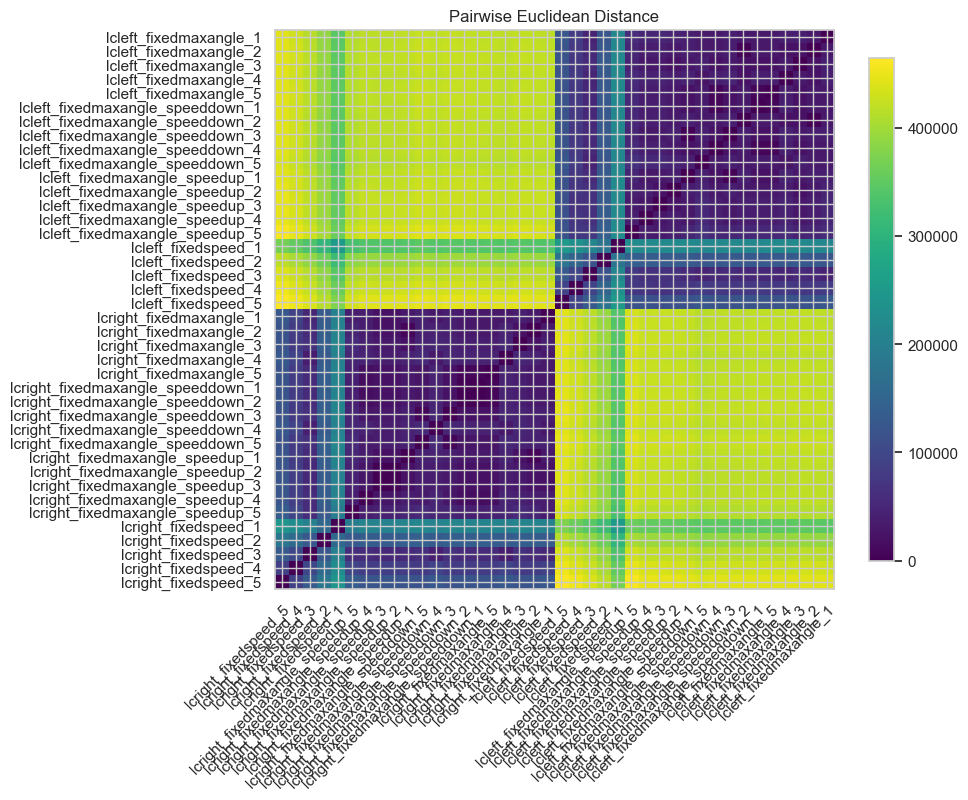

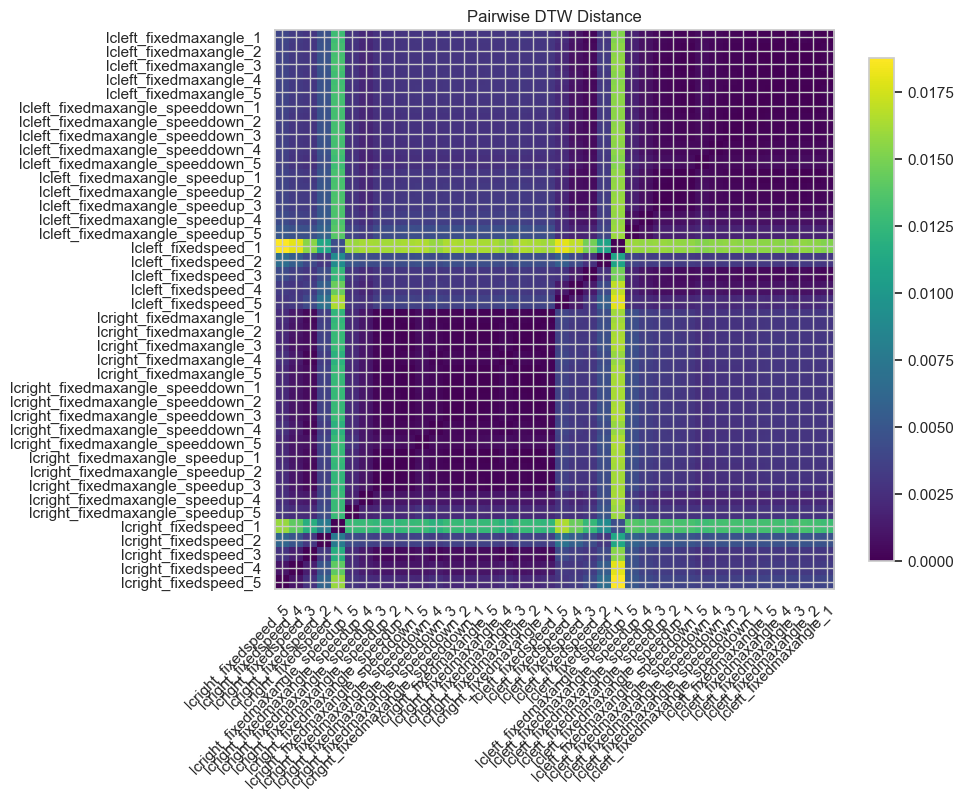

In [15]:
heatmap_fig = plot_heatmap(euclidean_distance_matrix, column_names=file_basenames,
                title_text='Pairwise Euclidean Distance')
heatmap_fig.savefig(parentFolder + "/Euclidean_Distances_Heatmap.png")

heatmap_fig = plot_heatmap(dtw_distance_matrix, column_names=file_basenames,
                title_text='Pairwise DTW Distance')
heatmap_fig.savefig(parentFolder + "/DTW_Distances_Heatmap.png")